### Установка необходимых пакетов и импорт библиотек

In [ ]:
!pip install emoji==1.4.1
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.1-py3-none-any.whl size=186377 sha256=07e420bd865080c380539405d922a0700e6c96514a4f453ee001c0ba44ec91f6
  Stored in directory: /root/.cache/pip/wheels/35/27/d6/a425b9b845119a8e2f1fb85f405bc4ba2a836bd2805c3c8403
Successfully built emoji


In [ ]:
import numpy as np

# Работа с датафреймом
import pandas as pd


# Обработка данных
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


# Результаты BERT и roBert мы сравним с наивным байесовским классификатором
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Токены и модели из библиотеки transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
import tensorflow as tf
from tensorflow import keras

# Метрики
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Для воспроизводимости результатов
seed=42

# Настройка стилей для графиков
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

<ipython-input-3-c3ab30836ef0>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [ ]:
# или в более новых версиях
df = pd.read_csv('/content/reviews.csv', encoding='utf-8', on_bad_lines='skip')

In [ ]:
df.head()

,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
2,"В Apple окончательно решили не заморачиваться,...",3
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон. Пользоваться одно удовольст...,5


In [ ]:
#df = df.drop(columns=['Restaurant', 'Reviewer', 'Metadata', 'Time', 'Pictures', '7514'])

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.shape

(321106, 2)

In [ ]:
df.isna().sum()

,0
Review,5
Rating,0


In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321101 entries, 0 to 458432
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  321101 non-null  object
 1   Rating  321101 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.3+ MB


In [ ]:
df.shape

(321101, 2)

In [ ]:
df = df.iloc[:40000]

Импортируем библиотеки:

# Вспомогательные функции

Определим функцию для вывода матрицы ошибок.

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels = ['1', '2', '3', '4', '5']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

### Предобработка и анализ данных

In [ ]:
df.rename(columns={'Review': 'OriginalTweet', 'Rating': 'Sentiment'}, inplace=True)

Определим функцию очистки

In [ ]:
# Очистка emojis из текстов
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)  # удаляем emoji (смайлики)

# Удаляем пунктуацию, ссылки, упоминание других участников, символы конца строки и переноса \r\n
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()  # удаляем \n и \r и переводим строку в нижний регистр
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # удаление ссылок и упоминаний других участников
    text = re.sub(r'[^\x00-\x7fА-Яа-яЁё]', r'', text)  # удаление символов не utf8/ascii, оставляя кириллицу
    banned_list = string.punctuation + '…' + '«' + '»' + '—'  # добавление специфичных для русского символов
    table = str.maketrans('', '', banned_list)  # создание словаря замены
    text = text.translate(table)  # применение к строке словаря замены
    return text

# Убираем хэштеги в конце предложения и оставляем в середине, удалив только символ #
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\wа-яА-ЯёЁ-]+(?=(?:\s+#[\wа-яА-ЯёЁ-]+)*\s*$)', tweet))  # удаление последнего хэштега
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))  # удаление символа хэштега в середине предложения
    return new_tweet2

# Фильтрация специальных символов, таких как & и $, присутствующих в некоторых словах
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('&' in word):  # Убираем слова, содержащие '&'
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):  # удаление множественных пробелов с помощью регулярки
    return re.sub("\s\s+", " ", text)

Применим функции для очистки

In [ ]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Теперь мы можем создать новую колонку `text_clean` для размещения очищенной версии текста твитов.

In [ ]:
df['text_clean'] = texts_new

In [ ]:
df['text_clean'].head()

,text_clean
0,3d touch просто восхитительная вещь заряд держ...
1,отключается при температуре близкой к нулю неп...
2,в apple окончательно решили не заморачиваться ...
3,постарался наиболее ёмко и коротко описать все...
4,достойный телефон пользоваться одно удовольствие


In [ ]:
df['OriginalTweet'][1:4].values

array(['Отключается при температуре близкой к нулю, непонятно ведет себя батарея',
       'В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать сказки про великолепную оптимизацию iOS, чудес на свете не бывает, этого мало. Те кто скажет, что их не волнуют технические характеристики смартфона, главное чтоб он хорошо работал, телефон за 5000 будет так же хорошо работать, а отдавая (выбрасывая) 55000 нужно думать головой и понимать, что этих денег данный тел

In [ ]:
df['text_clean'][1:4].values

array(['отключается при температуре близкой к нулю непонятно ведет себя батарея',
       'в apple окончательно решили не заморачиваться делая незначительные изменения в телефоне выдают эти изменения за инновации на этот раз скопировали не только функционал но и дизайн цена и была неадекватно завышена а после скачка курса так и говорить об этом не приходится многие скажут что и hd разрешения будет достаточно для такой диагонали может так оно и есть но аппарат позиционируется как топовое решение а в итоге получаем банальную экономию производителя ведь что произойдёт с временем работы если увеличить до fhd 1 гб оперативки тоже прошлый век и не надо рассказывать сказки про великолепную оптимизацию ios чудес на свете не бывает этого мало те кто скажет что их не волнуют технические характеристики смартфона главное чтоб он хорошо работал телефон за 5000 будет так же хорошо работать а отдавая выбрасывая 55000 нужно думать головой и понимать что этих денег данный телефон просто непросто не може

Также давайте создадим столбец для оценки длины очищенного текста, чтобы контролировать, а не удалили ли мы весь твит?

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

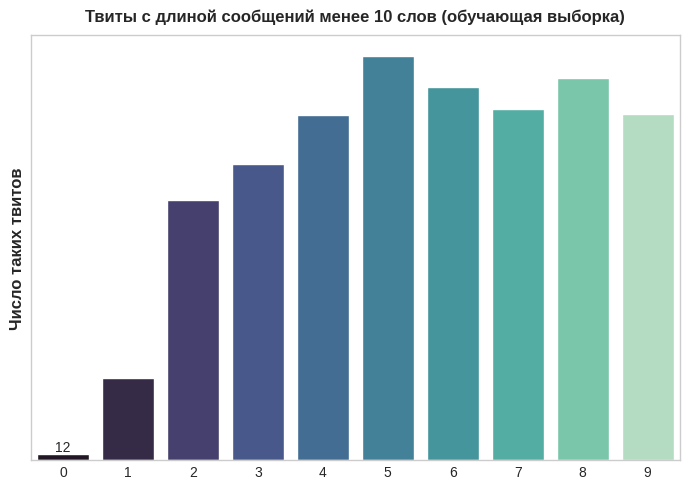

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (обучающая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

In [ ]:
print(f"Форма обучающей выборки: {df.shape}")

Форма обучающей выборки: (40000, 4)


In [ ]:
df = df[df['text_len'] > 4] # удаляем из обучающей выборки твиты короче 4 слов

In [ ]:
print(f"Форма обучающей выборки после очистки: {df.shape}")

Форма обучающей выборки после очистки: (37953, 4)


### Токенизация

Будем использовать предобученный BERT-токенизатор.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("kazars24/rubert-ner-drugname")

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.57M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Применим токенизатор к "очищенным" данным:

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 482


In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))




Эти последовательности не на английском языке и должны быть удалены.
Отсортируем по убыванию числа токенов предложения:

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='text_len', ascending=False)
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
7083,Хочу оставить свой отзыв об этом телефоне. \rМ...,5,хочу оставить свой отзыв об этом телефоне мне ...,354,450
30001,"Встаю в 8 утра. В 9.30 выезжаю из дома, домой ...",5,встаю в 8 утра в 930 выезжаю из дома домой при...,353,430
7074,Имел опыт поюзать такие телефоны как HTC Daimo...,3,имел опыт поюзать такие телефоны как htc daimo...,347,423
21674,"Начну с того, что Эппл сами себе навредили, на...",5,начну с того что эппл сами себе навредили назв...,342,403
41017,Выбирала этот телефон достаточно долго. Ориети...,2,выбирала этот телефон достаточно долго ориетир...,342,410


In [ ]:
filtered_df = df.loc[df['token_lens'] < 100]

In [ ]:
filtered_df.shape

(26861, 5)

In [ ]:
df = filtered_df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26861 entries, 38001 to 11331
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  26861 non-null  object
 1   Sentiment      26861 non-null  int64 
 2   text_clean     26861 non-null  object
 3   text_len       26861 non-null  int64 
 4   token_lens     26861 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [ ]:
#df = df.iloc[16:]

In [ ]:
df.shape

(26861, 5)

Теперь набор данных выглядит более чистым. Мы перетасуем его и сбросим индекс.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

### Анализ колонки Sentiment (Настроение)

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
5,13722
4,5893
3,3309
2,2075
1,1862


In [ ]:
#df.drop(df[df['Sentiment'] == 7].index, inplace=True)
#df.drop(df[df['Sentiment'] == 9].index, inplace=True)
#df.drop(df[df['Sentiment'] == 0].index, inplace=True)

### Балансировка классов

С помощью метода `RandomOverSampler`, мы увеличим выборки для классов с меньшим числом образцов. Это можно сделать различными способами, например, путем дублирования существующих примеров, генерации синтетических данных или комбинирования этих методов.

In [ ]:
# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличения выборки к данным (X_resampled, y_resampled = ros.fit_resample(X, y))
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));

# Снова объединим выборки в DataFrame
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

В этом примере мы используем библиотеку `imbalanced-learn` для увеличения выборки с помощью `RandomOverSampler`. Этот метод случайным образом выбирает примеры из класса c меньшим числом примеров и дублирует их, пока не будет достигнут баланс.

In [ ]:
train_os['Sentiment'].value_counts()

,count
Sentiment,
5,13722
3,13722
1,13722
2,13722
4,13722


Теперь классы сбалансированы.

### Обучающая, проверочная и тестовая выборки

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### One hot encoding

Также сделаем копии наших выборок, они нам еще пригодятся:

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder() # создаем экземпляр класса OneHotEncoder()

# Формируем кодированные OHE метки для тренировочной, проверочной и тестовой выборок
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"Тренировочная выборка: {X_train.shape[0]}")
print(f"Проверочная выборка: {X_valid.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")

Тренировочная выборка: 54888
Проверочная выборка: 6861
Тестовая выборка: 6861


### Базовая модель: Наивный байесовский классификатор

Токенизируем твиты, используя CountVectorizer:

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Преобразуем токенизированные твиты в формат TF-IDF (частота использования термина, умноженная на частоту использования документа):

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Создаем модель наивного байесовского классификатора:

In [ ]:
nb_clf = MultinomialNB()

Обучим его:

In [ ]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

Запустим предсказание на тестовой выборке:

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

Выведем метрики с помощью метода `classification_report` библиотеки `sklearn`:

In [ ]:
print('Расчет метрик для наивного байесовского классификатора:')
print()
print()
print(classification_report(y_test_le, nb_pred, target_names=['5', '4', '3', '2', '1']))


Расчет метрик для наивного байесовского классификатора:


              precision    recall  f1-score   support

           5       0.88      0.92      0.90      1372
           4       0.84      0.89      0.86      1385
           3       0.80      0.83      0.81      1357
           2       0.71      0.71      0.71      1423
           1       0.76      0.65      0.70      1324

    accuracy                           0.80      6861
   macro avg       0.80      0.80      0.80      6861
weighted avg       0.80      0.80      0.80      6861



### Классификация с помощью BERT

In [ ]:
def tokenize(data, max_len=128):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',  # Убедитесь, что последовательности имеют одинаковую длину
            truncation=True,       # Обрезаем длинные последовательности
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
 # Преобразуем списки в NumPy массивы
    return np.array(input_ids), np.array(attention_masks)

In [ ]:
# Применяем функцию tokenize к выборкам
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

Применим функцию токенизатора к наборам данным и получим соответствующие маски:

Теперь мы можем импортировать предварительно обученную BERT модель из библиотеки Hugging face.

In [ ]:
bert_model = TFBertModel.from_pretrained("kazars24/rubert-ner-drugname") # префикс TF означает, что модель для TensorFlow

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def create_model(bert_model, max_len=128):

    # Параметры обучения
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7) # оптимизатор - Adam
    loss = tf.keras.losses.CategoricalCrossentropy()                      # функция потерь - категориальная кросс-энтропия
    accuracy = tf.keras.metrics.CategoricalAccuracy()                     # метрика - категориальная точность


    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')         # вход для токенизированной последовательности

    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')   # маска

    embeddings = bert_model([input_ids, attention_masks])[1]            # BERT-модель

    output = tf.keras.layers.Dense(5, activation="softmax")(embeddings) # полносвязный слой для классификации OHE

    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  multiple                     1778534   ['input_7[0][0]',             
 )                                                        40         'input_8[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 5)                    3845      ['tf_bert_model[3][1]'] 

Запускаем fine-tuning BERT трансформера:

In [ ]:
history_bert = model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_valid), epochs=4, batch_size=16)

Epoch 1/4
3431/3431 [==============================] - 1684s 485ms/step - loss: 1.0675 - categorical_accuracy: 0.5363 - val_loss: 0.6554 - val_categorical_accuracy: 0.7393
Epoch 2/4
3431/3431 [==============================] - 1664s 485ms/step - loss: 0.5281 - categorical_accuracy: 0.7923 - val_loss: 0.3982 - val_categorical_accuracy: 0.8389
Epoch 3/4
3431/3431 [==============================] - 1662s 484ms/step - loss: 0.3149 - categorical_accuracy: 0.8787 - val_loss: 0.3403 - val_categorical_accuracy: 0.8800
Epoch 4/4
3431/3431 [==============================] - 1645s 479ms/step - loss: 0.2162 - categorical_accuracy: 0.9191 - val_loss: 0.3280 - val_categorical_accuracy: 0.8851


In [ ]:
# Сохранение модели в формате TensorFlow SavedModel
model.save('my_model')

In [ ]:
# Сохранение модели в формате HDF5
model.save('my_model.h5')

Запустим предсказание на тестовой выборке:

In [ ]:
result_bert = model.predict([test_input_ids, test_attention_masks])

215/215 [==============================] - 69s 307ms/step


Возвращаем метку наиболее вероятного класса и строим матрицу ошибок:

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

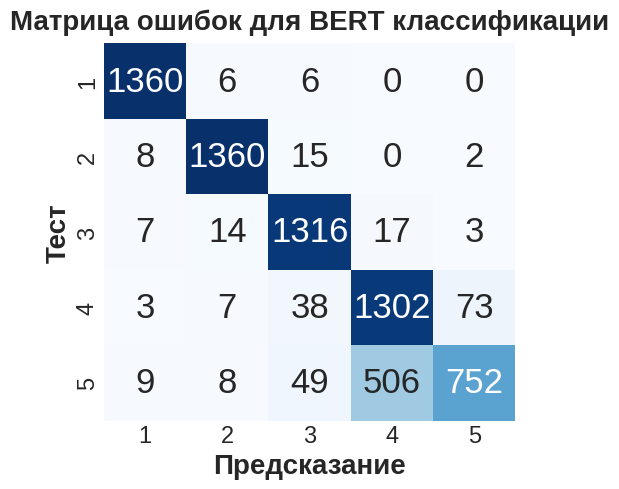

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'Матрица ошибок для BERT классификации')

In [ ]:
print('Расчет метрик для BERT классификатора:')
print()
print()
print(classification_report(y_test, y_pred_bert, target_names=['5', '4', '3', '2', '1']))

Расчет метрик для BERT классификатора:


              precision    recall  f1-score   support

           5       0.98      0.99      0.99      1372
           4       0.97      0.98      0.98      1385
           3       0.92      0.97      0.95      1357
           2       0.71      0.91      0.80      1423
           1       0.91      0.57      0.70      1324

   micro avg       0.89      0.89      0.89      6861
   macro avg       0.90      0.89      0.88      6861
weighted avg       0.90      0.89      0.88      6861
 samples avg       0.89      0.89      0.89      6861



In [ ]:
for i in range(len(X_test[:10])):
    print(f'Text: {X_test[i]}')
    print(f'Predicted Class: {y_pred_bert[i]}')
    print(f'True Class: {y_test[i]}')
    print('-' * 50)

Text: в общем хороший телефон не стоимость его завышена
Predicted Class: [0. 1. 0. 0. 0.]
True Class: [0. 0. 1. 0. 0.]
--------------------------------------------------
Text: неплохой телефон для людей без сильных требований сносная камера долго держит зарядку при первом включении телефон напичкан мало нужными программами но это не так значительно отключить большую часть и будет вам радость
Predicted Class: [0. 0. 1. 0. 0.]
True Class: [0. 0. 1. 0. 0.]
--------------------------------------------------
Text: не покупайте этот смартфон не повторяйте ошибки пользуюсь данным аппаратом месяц и очень жалею о покупке просто есть с чем сравнивать до этого был сони м2 дуал проблем не было вообще хороший аппарат и работал хорошо и аккумулятор первые 15 года держал отлично с утра до ночи при интенсивной эксплуатации смело
Predicted Class: [1. 0. 0. 0. 0.]
True Class: [1. 0. 0. 0. 0.]
--------------------------------------------------
Text: использую около 2х лет аккумулятор держит так же как и 